In [156]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
%config InlineBackend.figure_format = 'svg'


In [157]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound

In [158]:
class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [159]:
from copy import deepcopy


class DDPG:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = deepcopy(self.actor)
        self.target_critic = deepcopy(self.critic)

        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)

In [160]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.1  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'Pendulum-v1'
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值


d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [161]:
def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    reward += -state[0] * state[0] * 0.1
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [162]:
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

In [163]:
return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s, episode=200, return=90.052]


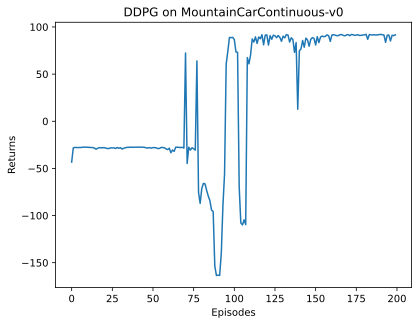

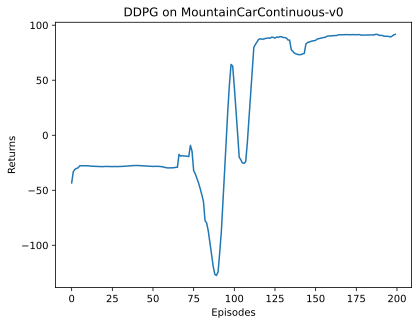

In [164]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

In [168]:
import cv2
from matplotlib import animation 

def display_frames_as_gif(frames):
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
   
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=1)
    anim.save('./DDPG_result.gif', writer='ffmpeg', fps=30)
    
def run_game(env):
    frames = []
    s = env.reset()
    rewards = 0
    for i_episode in range(1000):
        frames.append(env.render(mode='rgb_array'))
        # time.sleep(0.1)
        action = agent.take_action(s)
        s_, r, done, info = env.step(action)   
        print(s_)
        s = s_
        rewards += r
        if done:  
            break
    
    display_frames_as_gif(frames)
    
    # env.close()
    return rewards


d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


[-0.4810089  -0.00145672]
[-0.48423728 -0.00322839]
[-0.48891744 -0.00468016]
[-0.4951197  -0.00620226]
[-0.5029779  -0.00785822]
[-0.51230514 -0.00932725]
[-0.5230208  -0.01071564]
[-0.535069   -0.01204818]
[-0.54851043 -0.01344142]
[-0.5632652  -0.01475475]
[-0.5790611  -0.01579589]
[-0.5959429  -0.01688184]
[-0.6136469  -0.01770399]
[-0.6321812  -0.01853431]
[-0.6512639  -0.01908268]
[-0.67077374 -0.01950988]
[-0.69049656 -0.0197228 ]
[-0.71032935 -0.01983282]
[-0.7303338  -0.02000445]
[-0.7502749  -0.01994111]
[-0.7696585  -0.01938359]
[-0.788824   -0.01916554]
[-0.8074293  -0.01860528]
[-0.8252361  -0.01780679]
[-0.8422483  -0.01701221]
[-0.8582204  -0.01597206]
[-0.8727271  -0.01450669]
[-0.8856378  -0.01291074]
[-0.89636993 -0.01073212]
[-0.9044378  -0.00806784]
[-0.9096168  -0.00517903]
[-0.9118913  -0.00227448]
[-9.1098344e-01  9.0786739e-04]
[-0.9065989   0.00438449]
[-0.89878845  0.00781046]
[-0.8875035   0.01128498]
[-0.87279826  0.01470525]
[-0.85442746  0.01837081]
[-0.83

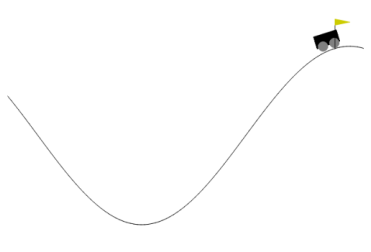

In [169]:
env.reset()
rewards = run_game(env)
print(rewards)